# 基本自动求导（Automatic Differentiation AD）

自动求导有两种形式，其分别为前向模式（Forward Mode）和反向模式（Reverse Mode）

* Forward Mode依靠**二元数**，在前向运算过程中同时计算值和导数值
* Reverse Mode分为两个步骤，第一步为前向运算，第二步为反向传播

参考论文：[Automatic Differentiation in Machine Learning: a Survey](https://arxiv.org/pdf/1502.05767.pdf)

参考实现：[autograd-by-borgwang](https://github.com/borgwang/toys/blob/master/ml-autograd/autograd.ipynb)

参考解析：

1. [神经网络自动求导的设计与实现](https://zhuanlan.zhihu.com/p/82582926)

2. [tensorflow的函数自动求导是如何实现的](https://www.zhihu.com/question/54554389)

在这里，由于是对神经网络的分析，因此主要讨论自动求导的**Reverse Mode**

## AD实现要点

对于AD，其在运算过程中需要记录如下数据

* 当前运算的运算结果
* 当前运算的梯度计算方法
* 当前运算直接依赖的前置运算

## AD过程：

假设已完成前向计算，并保留了上述需要的数据

* 从整个运算的结果出发，记录当前运算的梯度，并将梯度传递给当前运算直接依赖的前置运算
* 递归上述步骤，直到所有计算结束

## 基于AD的神经网络优化流程
* **运算定义**：若要实现AD，每一个运算不仅要计算结果，还需要对运算的前置依赖关系以及梯度计算方法进行记录
* **反向传播**: 在完成正向计算后，需要进行反向传播
* **参数更新**：在完成反向传播后，依靠梯度计算结果更新参数

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(1024)
np.random.seed(1024)

In [41]:
def as_tensor(obj):
    if not isinstance(obj, MyTensor):
        obj = MyTensor(obj)
    return obj

def build_binary_ops_result_tensor(tensor1, tensor2, grad_func_tensor1, grad_func_tensor2, values):
    """
    建立二元运算结果的tensor
    """
    requires_grad = tensor1.requires_grad or tensor2.requires_grad
    
    dependency = list()
    if tensor1.requires_grad:
        dependency.append({"tensor": tensor1, "grad_func": grad_func_tensor1})
    if tensor2.requires_grad:
        dependency.append({"tensor": tensor2, "grad_func": grad_func_tensor2})

    return MyTensor(values, requires_grad, dependency)

def build_unary_ops_result_tensor(tensor, grad_func, values):
    """
    建立一元运算结果的tensor
    """

    requires_grad = tensor.requires_grad
    dependency = list()

    if tensor.requires_grad:
        dependency.append({"tensor": tensor, "grad_func": grad_func})
    
    return MyTensor(values, requires_grad, dependency) 


class MyTensor(object):

    def __init__(self, values, requires_grad=False, dependency=None):
        self._values = np.array(values)
        self._shape = self._values.shape

        self.grad = None
        self.requires_grad = requires_grad

        if self.requires_grad:
            self.zero_grad()

        if dependency is None:
            self.dependency = list()
        else:
            self.dependency = dependency
        
    def zero_grad(self):
        self.grad = np.zeros(self._shape)
    
    @property
    def values(self):
        return self._values
    
    @ property
    def shape(self):
        return self._shape
    
    @values.setter
    def values(self, values):
        self._values = np.array(values)
        self.grad = None

    def backward(self, grad=None):
        """
        反向传播核心代码，累计当前tensor的梯度，同时反向传播梯度
        """
        assert self.requires_grad, "Call backward() on a non-requires-grad tensor"

        if grad is None:
            grad = 1.0
        grad = np.array(grad)

        # 梯度叠加
        self.grad += grad

        # 反向传播梯度到直接依赖的运算
        for dep in self.dependency:
            # 注意这里是直接将梯度传播到依赖的运算，而不是传播梯度叠加的结果
            # 其原因在于这里使用的是深度优先遍历
            # 由于在反向传播梯度后，会进行直接依赖的运算反向传播，因此是深度优先
            # 这么一来在遍历完成后，所有经过当前运算传递到依赖运算的路径均会被搜索到
            
            # 比如
            # 假设当前节点前有两个后继节点
            # 那么反向传播流程为

            # 梯度清零
            # 后继节点一反向传播，当前节点梯度+grad_1
            # 当前节点继续反向传播，前置节点梯度+grad_1
            # 另一条路径：后继节点二反向传播，当前节点梯度+grad_2
            # 当前节点继续反向传播，前置节点梯度+grad_2

            # 若在上述过程中每次传递的是累计梯度，则会导致前置节点梯度+grad_1+(grad_1+grad_2)
            # 即在第二条路径中对第一条路径的梯度又叠加了一次
            grad_cal_method_for_dep = dep["grad_func"](grad)
            # 迭代调用直接依赖的运算的反向传播
            dep["tensor"].backward(grad_cal_method_for_dep)
    
    # 运算重载，对于反向传播，其不仅要计算值，还需要计算梯度
    # 重载运算

    # 二元运算：
    # 矩阵乘法：左乘、右乘、原位乘
    # 加法：左加、右加、原位加
    # 减法：左减、右减、原位减
    # 按位乘法：左乘、右乘、原位乘

    # 一元运算：
    # 取反

    def __add__(self, other):
        """
        右加法重载
        
        return: self + other
        """
        return self._add(self, as_tensor(other))
    
    def __radd__(self, other):
        """
        左加法重载

        return: other + self
        """
        return self._add(as_tensor(other), self)
    
    def __iadd__(self, other):
        """
        原位加法重载

        self += other

        原位加法不会生成新的节点，因此不会记录梯度
        """
        self.values = self.values + as_tensor(other).values
        return self

    def _add(self, tensor1, tensor2):
        """
        运算为：c = a + b

        Dc/Da = 1
        Dc/Db = 1

        在本运算中，要求 a.shape == b.shape == c.shape
        或者使用numpy默认的broadcast机制

        对于维度匹配的加法，梯度直接传递即可
        对于维度无法匹配需要采用broadcast机制进行计算的加法，需要对维度进行处理

        broadcast机制：
        这里仅考虑二维的情况

        1. 对于形如 (m, n) + (n, ) -> (m, n)形式的broadcast:
        对于第一个加数，将计算结果的梯度直接赋予当前加数即可
        对于第二个加数，其需要将计算结果的梯度沿第一维度叠加，然后赋予当前加数

        2. 对于形如(m, n) + (1, n) -> (m, n)形式的broadcast：
        对于第一个加数，将计算结果的梯度直接赋予当前加数即可
        对于第二个加数，其需要将计算结果的梯度沿第一维度叠加，并保留维度，然后赋予当前加数
        """
        _result = tensor1.values + tensor2.values

        def grad_func_tensor1(grad):

            # 处理第一种情况
            # 此时，若当前tensor的维度要小于grad的维度，则说明存在第一种broadcast
            for _ in range(grad.ndim - tensor1.values.ndim):
                grad = grad.sum(axis=0)
            # 处理第二种情况
            # 此时，若当前tensor的维度等于grad的维度，但是存在为1的维度，则说明可能是第二种broadcast
            for i, dim in enumerate(tensor1.values.shape):
                if dim == 1:
                    grad = grad.sum(axis=i, keepdims=True)
            return grad

        def grad_func_tensor2(grad):
            # 同上
            for _ in range(grad.ndim - tensor2.values.ndim):
                grad = grad.sum(axis=0)
            for i, dim in enumerate(tensor2.values.shape):
                if dim == 1:
                    grad = grad.sum(axis=i, keepdims=True)
            return grad
        
        return build_binary_ops_result_tensor(tensor1, tensor2, grad_func_tensor1, grad_func_tensor2, _result)

    def __sub__(self, other):
        """
        右减法重载
        
        return: self - other
        """
        return self._sub(self, as_tensor(other))
    
    def __rsub__(self, other):
        """
        左减法重载

        return：other - self
        """
        return self._sub(as_tensor(other), self)
    
    def __isub__(self, other):
        """
        原位减法
        self -= other

        原位减法不会生成新的节点，因此不会记录梯度
        """
        self.values = self.values - as_tensor(other).values
        return self

    def _sub(self, tensor1, tensor2):
        """
        运算为：c = a - b

        Dc/Da = 1
        Dc/Db = -1
        在本运算中，要求 a.shape == b.shape == c.shape
        或者使用numpy默认的broadcast机制

        分析同_add
        """
        _result = tensor1.values - tensor2.values

        def grad_func_tensor1(grad):

            # 处理第一种情况
            # 此时，若当前tensor的维度要小于grad的维度，则说明存在第一种broadcast
            for _ in range(grad.ndim - tensor1.values.ndim):
                grad = grad.sum(axis=0)
            # 处理第二种情况
            # 此时，若当前tensor的维度等于grad的维度，但是存在为1的维度，则说明可能是第二种broadcast
            for i, dim in enumerate(tensor1.values.shape):
                if dim == 1:
                    grad = grad.sum(axis=i, keepdims=True)
            return grad

        def grad_func_tensor2(grad):
            # 同上
            for _ in range(grad.ndim - tensor2.values.ndim):
                grad = grad.sum(axis=0)
            for i, dim in enumerate(tensor2.values.shape):
                if dim == 1:
                    grad = grad.sum(axis=i, keepdims=True)
            return -grad
        
        return build_binary_ops_result_tensor(tensor1, tensor2, grad_func_tensor1, grad_func_tensor2, _result)
    
    def __matmul__(self, other):
        """
        矩阵右乘

        return self @ other
        """
        return self._matmul(self, as_tensor(other))
    
    def __rmatmul__(self, other):
        """
        矩阵左乘
        
        return other @ self
        """
        return self._matmul(as_tensor(other), self)
    
    def __imatmul__(self, other):
        """
        原位乘法
        self @= other
        """
        self.values = self.values @ as_tensor(other).values
        return self

    def _matmul(self, tensor1, tensor2):
        """
        运算为: c = a @ b

        Dc/Da = grad @ b.T
        Dc/Da = a.T @ grad
        """
        if tensor1.shape[1] != tensor2.shape[0]:
            raise RuntimeError("RuntimeError: size mismatch, m1: {}, m2: {}".format(tensor1.shape, tensor2.shape))

        _result = tensor1.values @ tensor2.values
        def grad_func_tensor1(grad):
            return grad @ tensor2.values.T
        
        def grad_func_tensor2(grad):
            return tensor1.values.T @ grad

        return build_binary_ops_result_tensor(tensor1, tensor2, grad_func_tensor1, grad_func_tensor2, _result)

    def __neg__(self):
        """
        取反运算
        return -self
        """
        return self._neg(self)
    
    def _neg(self, tensor):
        """
        运算为: c = -a

        Dc/Da = -1
        """
        _result = -tensor.values

        def grad_func(grad):
            return -grad
        
        return build_unary_ops_result_tensor(tensor, grad_func, _result)

    def __mul__(self, other):
        """
        按位右乘

        reture self * other
        """
        return self._mul(self, as_tensor(other))

    def __rmul__(self, other):
        """
        按位左乘

        return other * self
        """
        return self._mul(as_tensor(other), self)
    
    def __imul__(self, other):
        """
        原位按位乘

        self *= other
        """
        self.values = self.values * as_tensor(other).values
        return self

    def _mul(self, tensor1, tensor2):
        """
        运算为: c = a * b

        Dc/Da = b
        Dc/Db = a

        在本运算中，要求 a.shape == b.shape == c.shape
        或者使用numpy默认的broadcast机制

        对于维度匹配的加法，梯度直接传递即可
        对于维度无法匹配需要采用broadcast机制进行计算的加法，需要对维度进行处理

        由于
        Dc/Da = b
        Dc/Db = a
        因此在计算梯度时，不同于add，按位乘法需要依赖numpy的broadcast首先计算梯度值，然后处理维度问题
        即：
        tensor1.grad = grad * tensor2.grad
        tensor2.grad = grad * tensor1.grad

        维度处理同add
        """
        _result = tensor1.values * tensor2.values

        def grad_func_tensor1(grad):
            grad = grad * tensor2.values

            # 处理第一种情况
            # 此时，若当前tensor的维度要小于grad的维度，则说明存在第一种broadcast
            for _ in range(grad.ndim - tensor1.values.ndim):
                grad = grad.sum(axis=0)
            # 处理第二种情况
            # 此时，若当前tensor的维度等于grad的维度，但是存在为1的维度，则说明可能是第二种broadcast
            for i, dim in enumerate(tensor1.values.shape):
                if dim == 1:
                    grad = grad.sum(axis=i, keepdims=True)
            return grad

        def grad_func_tensor2(grad):
            grad = grad * tensor1.values
            # 同上
            for _ in range(grad.ndim - tensor2.values.ndim):
                grad = grad.sum(axis=0)
            for i, dim in enumerate(tensor2.values.shape):
                if dim == 1:
                    grad = grad.sum(axis=i, keepdims=True)
            return grad
        
        return build_binary_ops_result_tensor(tensor1, tensor2, grad_func_tensor1, grad_func_tensor2, _result)

    def sum(self, axis=None):
        return _sum(self, axis=axis)

    def mean(self, axis=None):
        return _mean(self, axis)


# sum
def _sum(tensor, axis=None):
    """
    运算：c = np.sum(a, axis)

    Dc/Da = 1

    若是求全部维度的和，即axis=None，则输出为grad * np.ones_list(a.shape)
    若是按照特定维度进行求和，则需要首先将grad扩展为和a相同的shape，然后输出
    """
    _result = tensor.values.sum(axis=axis)

    # 获取求和维度对应的shape
    if axis is not None:
        dim_repeat = tensor.values.shape[axis]

    def grad_func(grad):
        if axis is None:
            grad = grad * np.ones_like(tensor.values)
        else:
            # 维度扩展
            grad = np.expand_dims(grad, axis)
            # 重新生成shape
            grad = np.repeat(grad, dim_repeat, axis)
    
    return build_unary_ops_result_tensor(tensor, grad_func, _result)

# mean
def _mean(tensor, axis=None):
    """
    运算：c = np.mean(a, axis)

    Dc/Da = 1/len(a.shape[axis])

    若是求全部维度的均值，即axis=None，则输出为grad * np.ones_list(a.shape) / np.prod(a.shape)
    若是按照特定维度进行求和，则需要首先将grad扩展为和a相同的shape，然后输出
    """
    _result = tensor.values.mean(axis=axis)

    # 获取求和维度对应的shape
    if axis is not None:
        dim_repeat = tensor.values.shape[axis]

    def grad_func(grad):
        if axis is None:
            grad = grad * np.ones_like(tensor.values) / np.prod(tensor.values.shape)
        else:
            # 维度扩展
            grad = np.expand_dims(grad, axis)
            # 重新生成shape并除以相应的维度
            grad = np.repeat(grad, dim_repeat, axis) / np.prod(dim_repeat)
    
    return build_unary_ops_result_tensor(tensor, grad_func, _result)

# sigmoid
def sigmoid(tensor):
    """
    运算为 c = 1/(1+e^(-a))

    Dc/Da = c(1-c)
    """
    _result = 1/(1+np.power(np.e, -tensor.values))

    def grad_func(grad):
            return grad * _result

    return build_unary_ops_result_tensor(tensor, grad_func, _result)

# ReLU
def ReLU(tensor, inplace=False):
    """
    运算为 c = 0 if a<= 0 or c = a

    Dc/Da = 0 if a <= 0 or Dc/Da = 1

    # ATTENTION!!!!!
    # Inplace模式有严重 BUG，有待修复
    # TODO: Inplace Mode
    """
    # 建立mask
    _mask = np.array(tensor.values > 0).astype(np.int32)

    if inplace:
        # 直接原位操作
        tensor.values *= _mask
        # # 梯度处理
        def grad_func(grad):
            grad = grad * _mask
            return grad
        if tensor.requires_grad:
            tensor.dependency.append({"tensor": tensor, "grad_func": grad_func})
        return tensor
    else:
        _result = tensor.values * _mask

        def grad_func(grad):
            grad = grad * _mask
            return grad
        
        return build_unary_ops_result_tensor(tensor, grad_func, _result)

def Tanh(tensor, inplace=False):
    """
    运算为 c = (1-e^(-2x))/(1+e^(-2x))

    Dc/Da = 1 - c^2
    """
    exp_tensor = np.exp(-2 * tensor.values)
    _result = (1-exp_tensor)/(1+exp_tensor)

    def grad_func(grad):
        grad = grad * (1 - np.power(_result, 2))
        return grad
    
    return build_unary_ops_result_tensor(tensor, grad_func, _result)

In [44]:
### test

# training data
np.random.seed(1024)
random.seed(1024)
x = MyTensor(np.sort(np.random.normal(-1, 1.0, (100, 1)), axis=0))
y = MyTensor(np.exp(x.values) - 3) 

params = {
    "w_1": MyTensor(np.random.normal(0, 1.0, (1, 10)), requires_grad=True),
    "b_1": MyTensor(np.random.normal(0, 1.0, 10), requires_grad=True),
    "w_2": MyTensor(np.random.normal(0, 1.0, (10, 1)), requires_grad=True),
    "b_2": MyTensor(np.random.normal(0, 1.0, 1), requires_grad=True)
}

learng_rate = 6e-4
loss_list = []
for e in range(1, 51):
    # set gradient to zero
    for param in params.values():
        param.zero_grad()
    
    # forward
    hidden_1 = ReLU(x @ params["w_1"] + params["b_1"], inplace=False)
    predicted = hidden_1 @ params["w_2"] + params["b_2"]
    err = predicted - y
    loss = (err * err).mean()
    
    # backward automatically
    loss.backward()
    
    # updata parameters
    for param in params.values():
        param -= learng_rate * param.grad
        
    loss_list.append(loss.values)
    if e % 20 == 0:
        print("epoch-%i \tloss: %.4f" % (e, loss.values))

hidden_1 = ReLU(x @ params["w_1"] + params["b_1"], inplace=False)
predicted = hidden_1 @ params["w_2"] + params["b_2"]
predicted = predicted.values

epoch-20 	loss: 0.0828
epoch-40 	loss: 0.0536


Text(0, 0.5, 'loss')

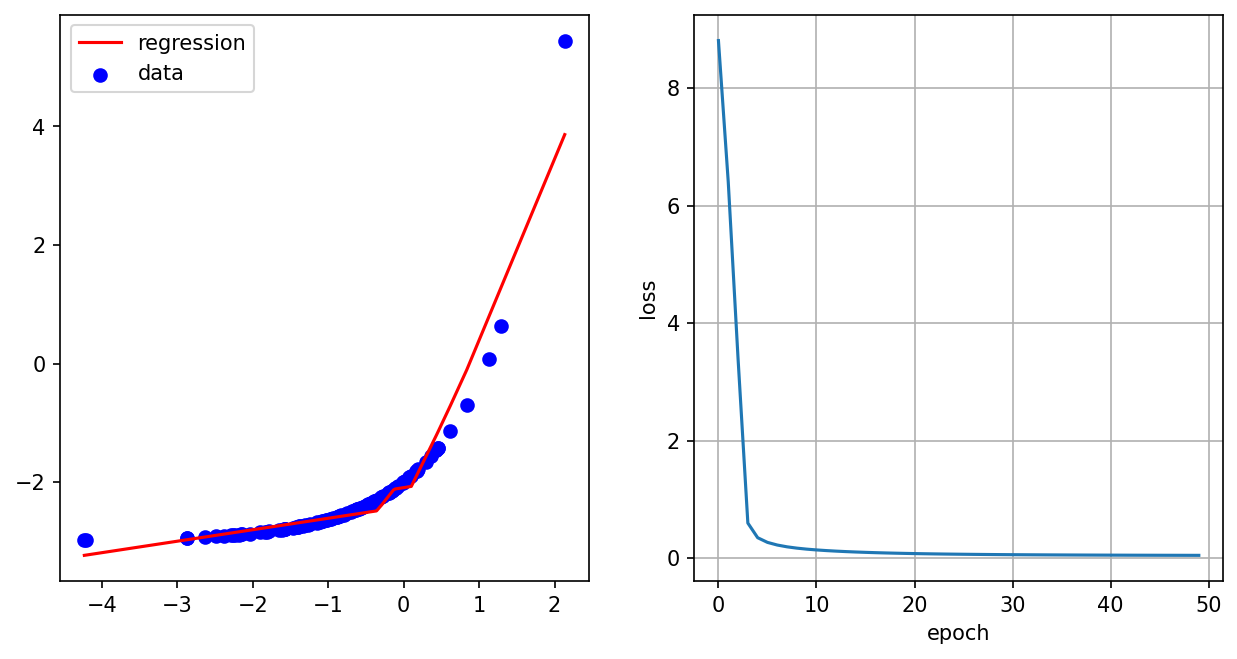

In [45]:
plt.figure(figsize=(10, 5), dpi=150)
plt.subplot(1, 2, 1)
plt.scatter(x.values, y.values, c="b", label="data")
plt.plot(x.values, predicted, c="r", label="regression")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss_list)
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")